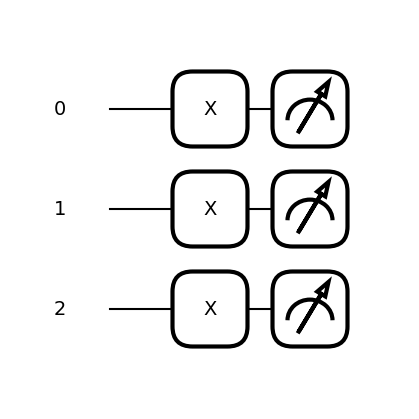

In [3]:
import pennylane as qml
import matplotlib.pyplot as plt


dev = qml.device('default.qubit', wires=3)

@qml.compile
@qml.qnode(dev)
def basic_embedding_circuit(m):
    qml.BasisEmbedding(m, wires=range(3))
    return qml.state()

m = 7
qml.draw_mpl(basic_embedding_circuit, show_all_wires=True)(m)
plt.show()

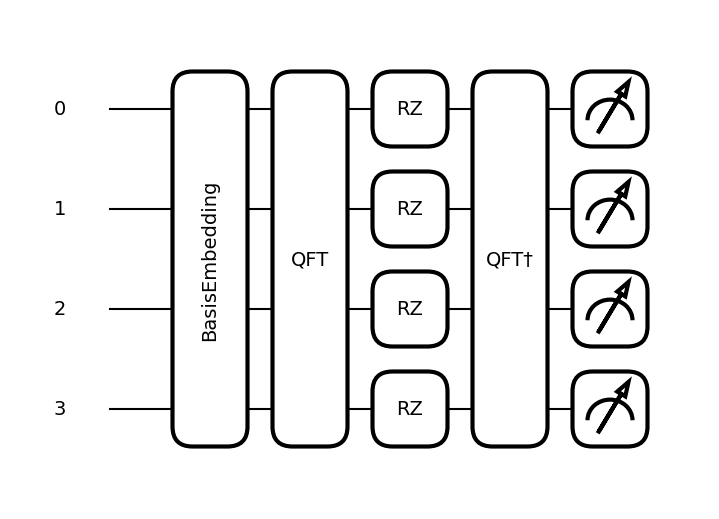

The ket representation of the sum of 3 and 7 is [1 0 1 0]


In [22]:
import pennylane as qml
import numpy as np

n_wires = 4
dev = qml.device('default.qubit', wires=n_wires, shots=1)

def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / 2**j, wires=wires[j])
        
@qml.qnode(dev)
def sum(m, k):
    qml.BasisEmbedding(m, wires=range(n_wires))
    qml.QFT(wires=range(n_wires))
    add_k_fourier(k, range(n_wires))
    qml.adjoint(qml.QFT)(wires=range(n_wires))
    return qml.sample()
qml.draw_mpl(sum, show_all_wires=True)(3,4)
plt.show()
print(f"The ket representation of the sum of 3 and 7 is {sum(3,7)}")

The ket representation of the sum of 7 and 3 is [0 0 1 1 0]


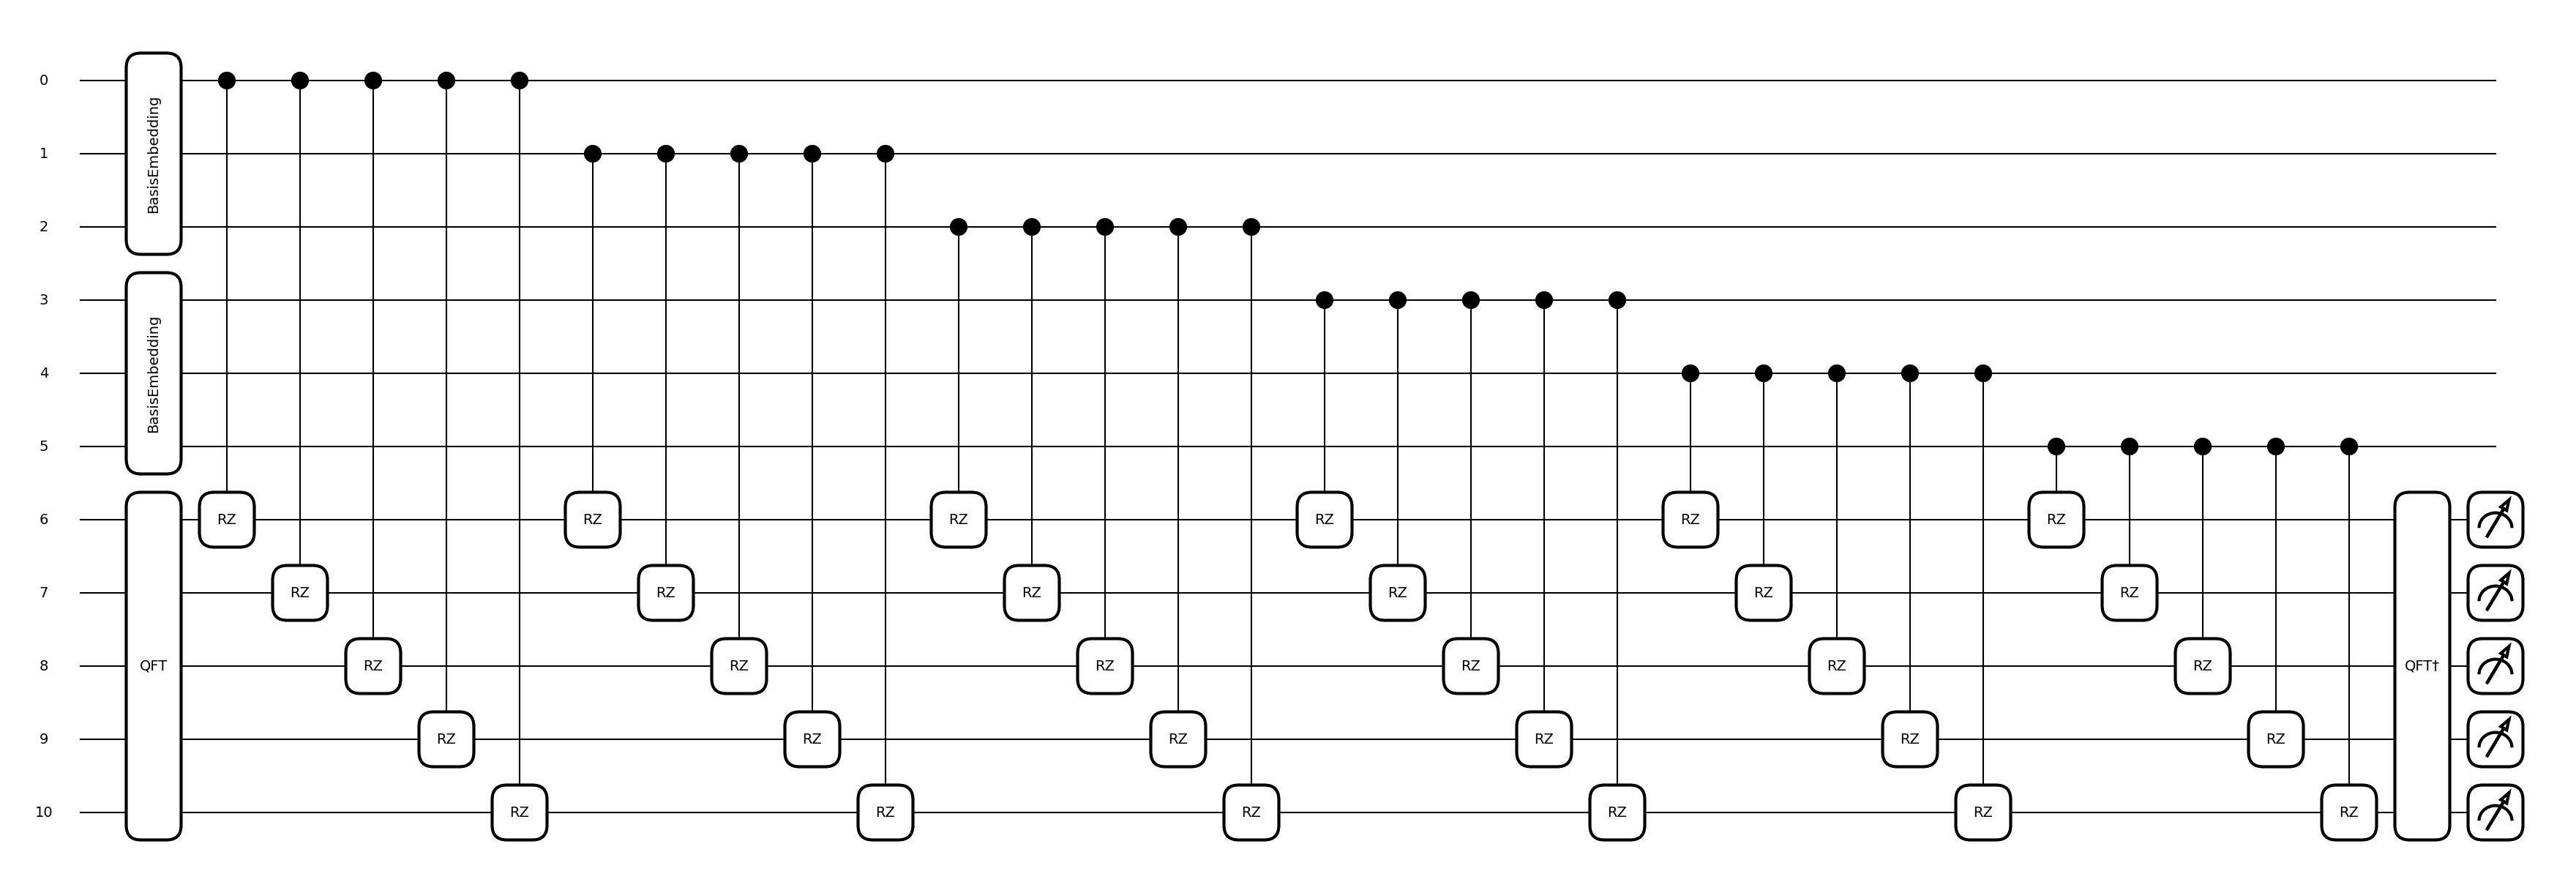

In [28]:
wires_m = [0, 1, 2]             # qubits needed to encode m
wires_k = [3, 4, 5]             # qubits needed to encode k
wires_solution = [6, 7, 8, 9, 10]   # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1)

n_wires = len(dev.wires) # total number of qubits used

def addition(wires_m, wires_k, wires_solution):
    # prepare solution qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_m)):
        qml.ctrl(add_k_fourier, control=wires_m[i])(2 **(len(wires_m) - i - 1), wires_solution)

    # add k to the counter
    for i in range(len(wires_k)):
        qml.ctrl(add_k_fourier, control=wires_k[i])(2 **(len(wires_k) - i - 1), wires_solution)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)

@qml.qnode(dev)
def sum2(m, k, wires_m, wires_k, wires_solution):
    # m and k codification
    qml.BasisEmbedding(m, wires=wires_m)
    qml.BasisEmbedding(k, wires=wires_k)

    # apply the addition circuit
    addition(wires_m, wires_k, wires_solution)

    return qml.sample(wires=wires_solution)

print(f"The ket representation of the sum of 7 and 3 is "
      f"{sum2(7, 3, wires_m, wires_k, wires_solution)}")

qml.draw_mpl(sum2, show_all_wires=True)(7, 3, wires_m, wires_k, wires_solution)
plt.show()

The ket representation of the multiplication of 3 and 7 is [1 0 1 0 1]


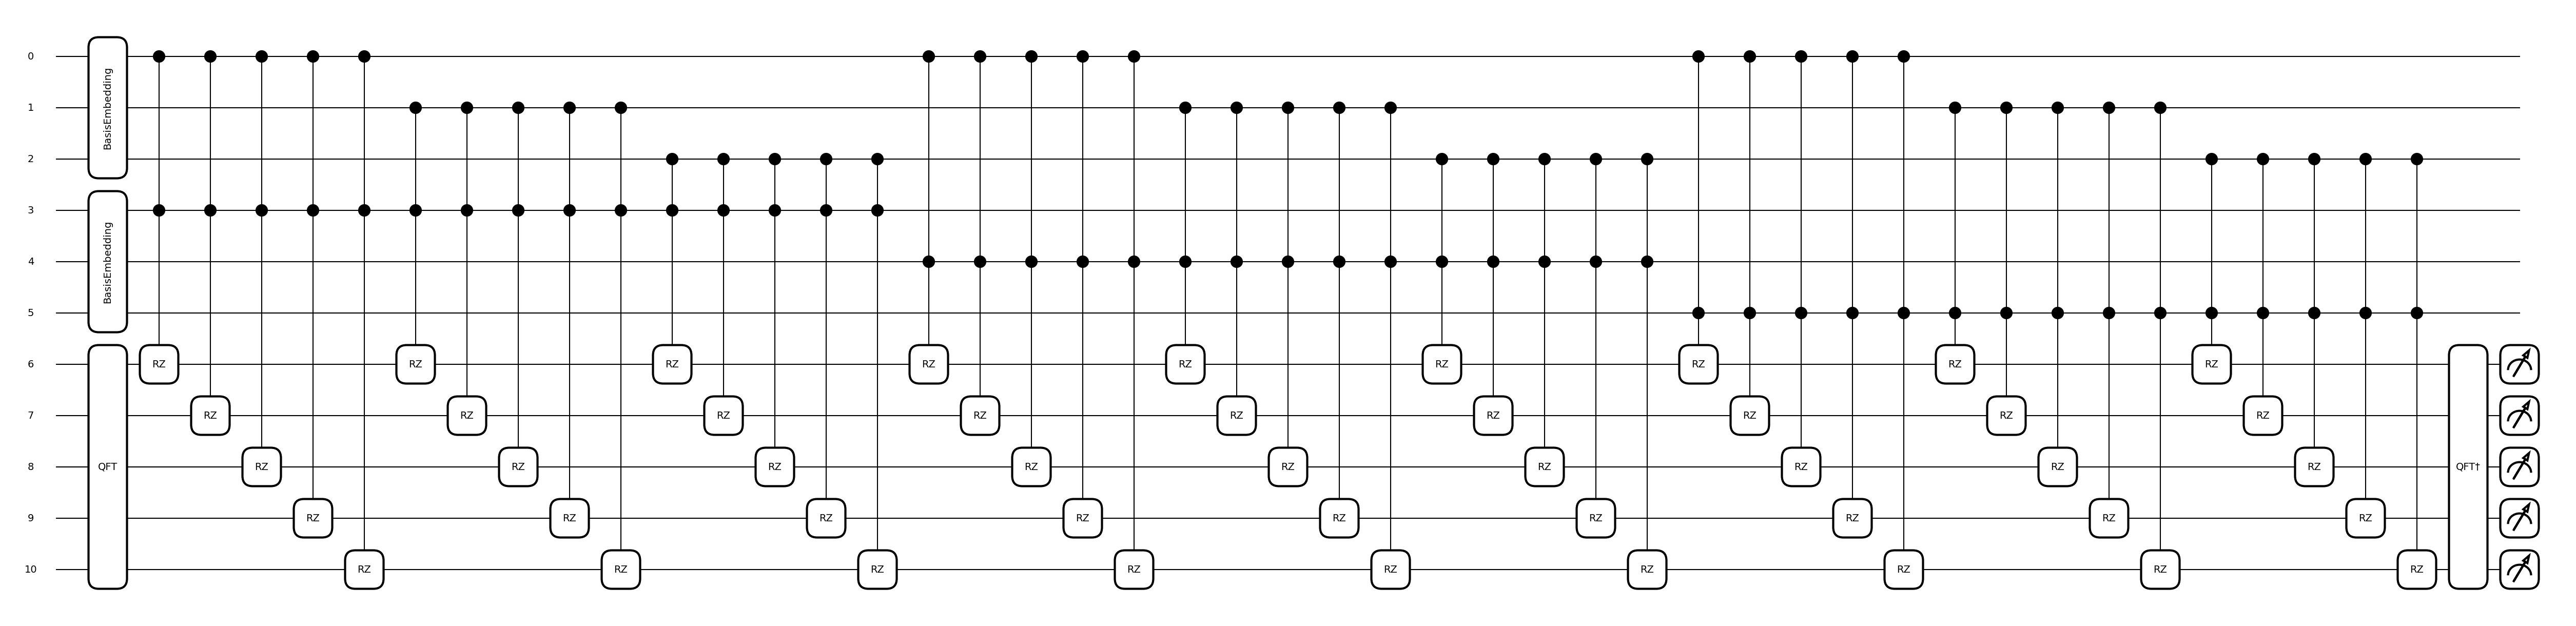

In [23]:
wires_m = [0, 1, 2]           # qubits needed to encode m
wires_k = [3, 4, 5]           # qubits needed to encode k
wires_solution = [6, 7, 8, 9, 10]  # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1)

n_wires = len(dev.wires)

def multiplication(wires_m, wires_k, wires_solution):
    # prepare sol-qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_k)):
        for j in range(len(wires_m)):
            coeff = 2 ** (len(wires_m) + len(wires_k) - i - j - 2)
            qml.ctrl(add_k_fourier, control=[wires_k[i], wires_m[j]])(coeff, wires_solution)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)

@qml.qnode(dev)
def mul(m, k):
    # m and k codification
    qml.BasisEmbedding(m, wires=wires_m)
    qml.BasisEmbedding(k, wires=wires_k)

    # Apply multiplication
    multiplication(wires_m, wires_k, wires_solution)

    return qml.sample(wires=wires_solution)


print(f"The ket representation of the multiplication of 3 and 7 is {mul(3,7)}")

qml.draw_mpl(mul, show_all_wires=True)(3, 7)
plt.show()

In [5]:
n = 21 # number we want to factor

wires_m = [0, 1, 2]                 # qubits needed to encode m
wires_k = [3, 4, 5]                 # qubits needed to encode k
wires_solution = [6, 7, 8, 9, 10]   # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution)

n_wires = len(dev.wires)

@qml.qnode(dev)
def factorization(n, wires_m, wires_k, wires_solution):
    # Superposition of the input
    for wire in wires_m:
        qml.Hadamard(wires=wire)

    for wire in wires_k:
        qml.Hadamard(wires=wire)

    # Apply the multiplication
    multiplication(wires_m, wires_k, wires_solution)

    # Change sign of n
    qml.FlipSign(n, wires=wires_solution)

    # Uncompute multiplication
    qml.adjoint(multiplication)(wires_m, wires_k, wires_solution)

    # Apply Grover operator
    qml.GroverOperator(wires=wires_m + wires_k)

    return qml.probs(wires=wires_m)


plt.bar(range(2 ** len(wires_m)), factorization(n, wires_m, wires_k, wires_solution))
plt.xlabel("Basic states")
plt.ylabel("Probability")
plt.show()

NameError: name 'qml' is not defined

          ┌──────────────────┐            
q_0: ─────┤0                 ├────────────
     ┌───┐│                  │            
q_1: ┤ X ├┤1                 ├────────────
     ├───┤│                  │            
q_2: ┤ X ├┤2                 ├────────────
     ├───┤│                  │            
q_3: ┤ X ├┤3                 ├────────────
     └───┘│  RGQFTMultiplier │┌─┐         
q_4: ─────┤4                 ├┤M├─────────
          │                  │└╥┘┌─┐      
q_5: ─────┤5                 ├─╫─┤M├──────
          │                  │ ║ └╥┘┌─┐   
q_6: ─────┤6                 ├─╫──╫─┤M├───
          │                  │ ║  ║ └╥┘┌─┐
q_7: ─────┤7                 ├─╫──╫──╫─┤M├
          └──────────────────┘ ║  ║  ║ └╥┘
c: 4/══════════════════════════╩══╩══╩══╩═
                               0  1  2  3 
2*3
---
SamplerResult(quasi_dists=[{6: 0.999999999999998}], metadata=[{}])
